## Function-1

In [24]:
import time

# Get notebook runtime
startTime = time.time()

In [25]:
import numpy as np
import pandas as pd
import joblib
import os

1. Should include entire pipeline, from data preprocessing to making final predictions.
2. It should take in raw data as input.
3. It should return predictions for your input. Here the input can be a single point or a set of points. <br>
def final_fun_1(X):<br>
.....<br>
.....<br>
..... # you will use the best model that you found out with your experiments<br>
return predictions made on X ( Raw Data)

### Load the raw test data

In [26]:
# Load the raw train data
Test_Provider = pd.read_csv("../output/Validation_Provider.csv")
Test_Beneficiary = pd.read_csv("../output/Validation_Beneficiary.csv")
Test_Inpatient = pd.read_csv("../output/Validation_Inpatient.csv")
Test_Outpatient = pd.read_csv("../output/Validation_Outpatient.csv")

In [27]:
Test_Provider.head()

,Provider,PotentialFraud
0,PRV51005,Yes
1,PRV51008,No
2,PRV51011,No
3,PRV51012,No
4,PRV51016,No


In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn import metrics
from sklearn.metrics import roc_curve, auc , f1_score
from sklearn.metrics import confusion_matrix
from sklearn.calibration import CalibratedClassifierCV
from sklearn.ensemble import RandomForestClassifier
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import random
from sklearn.preprocessing import StandardScaler

In [29]:
def create_feature_using_groupby(Test_df, gruopby_col, operation_col,operation):
    '''
    This function groupby the 'Train_df' and 'Test_df' dataframe by 'gruopby_col' and performs 'operation' on 'operation_col'
    '''
    
    for col in operation_col:
        # create new column name for the dataframe
        new_col_name = 'Per'+''.join(gruopby_col)+'_'+operation+'_'+col
        #print(new_col_name)
        Test_df[new_col_name] = Test_df.groupby(gruopby_col)[col].transform(operation)
    return Test_df

In [30]:
# define a function to preprocess raw test data
def preprocess_test_data(Test_Provider, Test_Beneficiary, Test_Inpatient, Test_Outpatient):
    
    # Replacing 2 with 0 for chronic conditions, Zero indicates chronic condition is No
    Test_Beneficiary = Test_Beneficiary.replace({'ChronicCond_Alzheimer': 2, 'ChronicCond_Heartfailure': 2, 'ChronicCond_KidneyDisease': 2,
                               'ChronicCond_Cancer': 2, 'ChronicCond_ObstrPulmonary': 2, 'ChronicCond_Depression': 2, 
                               'ChronicCond_Diabetes': 2, 'ChronicCond_IschemicHeart': 2, 'ChronicCond_Osteoporasis': 2, 
                               'ChronicCond_rheumatoidarthritis': 2, 'ChronicCond_stroke': 2 }, 0)

    # For RenalDiseaseIndicator replacing 'Y' with 1
    Test_Beneficiary = Test_Beneficiary.replace({'RenalDiseaseIndicator': 'Y'}, 1)

    # convert all these columns datatypes to numeric
    Test_Beneficiary[["ChronicCond_Alzheimer", "ChronicCond_Heartfailure", "ChronicCond_KidneyDisease", "ChronicCond_Cancer", "ChronicCond_ObstrPulmonary", "ChronicCond_Depression", "ChronicCond_Diabetes", "ChronicCond_IschemicHeart", "ChronicCond_Osteoporasis", "ChronicCond_rheumatoidarthritis", "ChronicCond_stroke", "RenalDiseaseIndicator"]] = Test_Beneficiary[["ChronicCond_Alzheimer", "ChronicCond_Heartfailure", "ChronicCond_KidneyDisease", "ChronicCond_Cancer", "ChronicCond_ObstrPulmonary", "ChronicCond_Depression", "ChronicCond_Diabetes", "ChronicCond_IschemicHeart", "ChronicCond_Osteoporasis", "ChronicCond_rheumatoidarthritis", "ChronicCond_stroke", "RenalDiseaseIndicator"]].apply(pd.to_numeric)

    # calculate patient risk score by summing up all risk scores
    Test_Beneficiary['Patient_Risk_Score'] = Test_Beneficiary['ChronicCond_Alzheimer'] + Test_Beneficiary['ChronicCond_Heartfailure'] + \
                                            Test_Beneficiary['ChronicCond_KidneyDisease'] + Test_Beneficiary['ChronicCond_Cancer'] +\
                                            Test_Beneficiary['ChronicCond_ObstrPulmonary'] + Test_Beneficiary['ChronicCond_Depression'] +\
                                        Test_Beneficiary['ChronicCond_Diabetes'] + Test_Beneficiary['ChronicCond_IschemicHeart'] +\
                                        Test_Beneficiary['ChronicCond_Osteoporasis'] + Test_Beneficiary['ChronicCond_rheumatoidarthritis'] +\
                                        Test_Beneficiary['ChronicCond_stroke'] + Test_Beneficiary['RenalDiseaseIndicator'] 

    # Replacing '2' with '0' for Gender Type
    Test_Beneficiary = Test_Beneficiary.replace({'Gender': 2}, 0)

    # Convert Date of Birth and Date of Death from String to Datetime format
    Test_Beneficiary['DOB'] = pd.to_datetime(Test_Beneficiary['DOB'] , format = '%Y-%m-%d')
    Test_Beneficiary['DOD'] = pd.to_datetime(Test_Beneficiary['DOD'],format = '%Y-%m-%d')

    # Get the birth month and Birth year for DOB and DOD
    Test_Beneficiary['Birth_Year'] = Test_Beneficiary['DOB'].dt.year
    Test_Beneficiary['Birth_Month'] = Test_Beneficiary['DOB'].dt.month

    Test_Beneficiary['Patient_Age'] = round(((Test_Beneficiary['DOD'] - Test_Beneficiary['DOB']).dt.days)/365)
    Test_Beneficiary.Patient_Age.fillna(round(((pd.to_datetime('2009-12-01',format ='%Y-%m-%d')-Test_Beneficiary['DOB']).dt.days)/365),inplace=True)

    # Set value=1 if the patient is dead i.e DOD value is not null
    Test_Beneficiary['isDead'] = 0
    Test_Beneficiary.loc[Test_Beneficiary.DOD.notna(), 'isDead'] = 1

    # convert ClaimStartDt, ClaimEndDt from string to datetime format
    Test_Inpatient['ClaimStartDt'] = pd.to_datetime(Test_Inpatient['ClaimStartDt'] , format = '%Y-%m-%d')
    Test_Inpatient['ClaimEndDt'] = pd.to_datetime(Test_Inpatient['ClaimEndDt'],format = '%Y-%m-%d')

    # convert AdmissionDt, DischargeDt from string to datetime format
    Test_Inpatient['AdmissionDt'] = pd.to_datetime(Test_Inpatient['AdmissionDt'] , format = '%Y-%m-%d')
    Test_Inpatient['DischargeDt'] = pd.to_datetime(Test_Inpatient['DischargeDt'],format = '%Y-%m-%d')

    # Calculate Hospitalization_Duration = DischargeDt - AdmissionDt
    Test_Inpatient['Hospitalization_Duration'] = ((Test_Inpatient['DischargeDt'] - Test_Inpatient['AdmissionDt']).dt.days)+1
    # Calculate Claim_Period = ClaimEndDt - ClaimStartDt
    Test_Inpatient['Claim_Period'] = ((Test_Inpatient['ClaimEndDt'] - Test_Inpatient['ClaimStartDt']).dt.days)+1

    # ExtraClaimDays = Claim_Period - Hospitalization_Duration
    Test_Inpatient['ExtraClaimDays'] = np.where(Test_Inpatient['Claim_Period']>Test_Inpatient['Hospitalization_Duration'], Test_Inpatient['Claim_Period'] - Test_Inpatient['Hospitalization_Duration'], 0)

    # Get the months and year of claim start and claim end
    Test_Inpatient['ClaimStart_Year'] = Test_Inpatient['ClaimStartDt'].dt.year
    Test_Inpatient['ClaimStart_Month'] = Test_Inpatient['ClaimStartDt'].dt.month
    Test_Inpatient['ClaimEnd_Year'] = Test_Inpatient['ClaimEndDt'].dt.year
    Test_Inpatient['ClaimEnd_Month'] = Test_Inpatient['ClaimEndDt'].dt.month

    # Get the month and year of Admission_Year and Admission_Month
    Test_Inpatient['Admission_Year'] = Test_Inpatient['AdmissionDt'].dt.year
    Test_Inpatient['Admission_Month'] = Test_Inpatient['AdmissionDt'].dt.month

    Test_Inpatient['Discharge_Year'] = Test_Inpatient['DischargeDt'].dt.year
    Test_Inpatient['Discharge_Month'] = Test_Inpatient['DischargeDt'].dt.month

    # convert ClaimStartDt, ClaimEndDt from string to datetime format
    Test_Outpatient['ClaimStartDt'] = pd.to_datetime(Test_Outpatient['ClaimStartDt'] , format = '%Y-%m-%d')
    Test_Outpatient['ClaimEndDt'] = pd.to_datetime(Test_Outpatient['ClaimEndDt'],format = '%Y-%m-%d')

    # Get the months and year of claim start and claim end
    Test_Outpatient['ClaimStart_Year'] = Test_Outpatient['ClaimStartDt'].dt.year
    Test_Outpatient['ClaimStart_Month'] = Test_Outpatient['ClaimStartDt'].dt.month
    Test_Outpatient['ClaimEnd_Year'] = Test_Outpatient['ClaimEndDt'].dt.year
    Test_Outpatient['ClaimEnd_Month'] = Test_Outpatient['ClaimEndDt'].dt.month

    # Calculate Claim_Period = ClaimEndDt - ClaimStartDt
    Test_Outpatient['Claim_Period'] = ((Test_Outpatient['ClaimEndDt'] - Test_Outpatient['ClaimStartDt']).dt.days)+1

    # Create a new column Inpatient_or_Outpatient where Inpatient =1 and Outpatient = 0
    Test_Inpatient['Inpatient_or_Outpatient'] = 1
    Test_Outpatient['Inpatient_or_Outpatient'] = 0

    # Merge inpatient and outpatient dataframes based on common columns
    common_columns_test = [ idx for idx in Test_Outpatient.columns if idx in Test_Inpatient.columns]
    Inpatient_Outpatient_Merge_Te = pd.merge(Test_Inpatient, Test_Outpatient, left_on = common_columns_test, right_on = common_columns_test,how = 'outer')

    # Merge beneficiary details with inpatient and outpatient data
    Inpatient_Outpatient_Beneficiary_Merge_Te = pd.merge(Inpatient_Outpatient_Merge_Te, Test_Beneficiary,
                                                      left_on='BeneID',right_on='BeneID',how='inner')

    Final_Dataset_Test = pd.merge(Inpatient_Outpatient_Beneficiary_Merge_Te, Test_Provider , how = 'inner', on = 'Provider' )

    # create new feature total reimbursement amount for inpatient and outpatient
    Final_Dataset_Test['IP_OP_TotalReimbursementAmt'] = Final_Dataset_Test['IPAnnualReimbursementAmt'] + Final_Dataset_Test['OPAnnualReimbursementAmt']
    # create new feature total deductible amount for inpatient and outpatient
    Final_Dataset_Test['IP_OP_AnnualDeductibleAmt'] = Final_Dataset_Test['IPAnnualDeductibleAmt'] + Final_Dataset_Test['OPAnnualDeductibleAmt']

    # Fill missing results using 0
    Final_Dataset_Test = Final_Dataset_Test.fillna(0).copy()
    
    # group by columns to create feature
    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'NoOfMonths_PartACov', 'NoOfMonths_PartBCov', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['Provider'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['BeneID'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['AttendingPhysician'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['OperatingPhysician'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['OtherPhysician'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['DiagnosisGroupCode'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmAdmitDiagnosisCode'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmProcedureCode_1'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmProcedureCode_2'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmProcedureCode_3'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmProcedureCode_4'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmProcedureCode_5'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmProcedureCode_6'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmDiagnosisCode_1'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmDiagnosisCode_2'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmDiagnosisCode_3'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmDiagnosisCode_4'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmDiagnosisCode_5'], columns, 'mean')

    columns = ['InscClaimAmtReimbursed', 'DeductibleAmtPaid', 'IPAnnualReimbursementAmt', 'IPAnnualDeductibleAmt', 'OPAnnualReimbursementAmt', 'OPAnnualDeductibleAmt', 'Patient_Age', 'Hospitalization_Duration', 'Claim_Period', 'Patient_Risk_Score']
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['ClmDiagnosisCode_6'], columns, 'mean')

    # Count the claims per provider
    Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, ['Provider'], ['ClaimID'], 'count')

    columns = ['ClaimID']
    grp_by_cols = ['BeneID', 'AttendingPhysician', 'OtherPhysician', 'OperatingPhysician', 'ClmAdmitDiagnosisCode', 'ClmProcedureCode_1',
                   'ClmProcedureCode_2', 'ClmProcedureCode_3', 'ClmProcedureCode_4', 'ClmProcedureCode_5', 'ClmDiagnosisCode_1', 'ClmDiagnosisCode_2',
                   'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4', 'ClmDiagnosisCode_5', 'ClmDiagnosisCode_6', 'DiagnosisGroupCode']
    for ele in grp_by_cols:
        lst = ['Provider', ele]
        Final_Dataset_Test =  create_feature_using_groupby(Final_Dataset_Test, lst, columns, 'count')

    # remove the columns which are not required
    remove_columns=['BeneID', 'ClaimID', 'ClaimStartDt','ClaimEndDt','AttendingPhysician','OperatingPhysician', 'OtherPhysician',
                    'ClmDiagnosisCode_1','ClmDiagnosisCode_2', 'ClmDiagnosisCode_3', 'ClmDiagnosisCode_4','ClmDiagnosisCode_5',
                    'ClmDiagnosisCode_6', 'ClmDiagnosisCode_7','ClmDiagnosisCode_8', 'ClmDiagnosisCode_9', 'ClmDiagnosisCode_10',
                    'ClmProcedureCode_1', 'ClmProcedureCode_2', 'ClmProcedureCode_3','ClmProcedureCode_4', 'ClmProcedureCode_5',
                    'ClmProcedureCode_6','ClmAdmitDiagnosisCode', 'AdmissionDt','ClaimStart_Year', 'ClaimStart_Year', 'ClaimStart_Month',
                    'ClaimEnd_Year', 'ClaimEnd_Month', 'Admission_Year', 'Admission_Month', 'Discharge_Year', 'Discharge_Month',
                    'DischargeDt', 'DiagnosisGroupCode','DOB', 'DOD','Birth_Year', 'Birth_Month','State', 'County']

    Final_Dataset_Test_FE=Final_Dataset_Test.drop(columns=remove_columns, axis=1)

    # Convert type of Gender and Race to categorical
    Final_Dataset_Test_FE.Gender=Final_Dataset_Test_FE.Gender.astype('category')
    Final_Dataset_Test_FE.Race=Final_Dataset_Test_FE.Race.astype('category')

    # Do one hot encoding for gender and Race
    Final_Dataset_Test_FE=pd.get_dummies(Final_Dataset_Test_FE,columns=['Gender','Race'])

    if "PotentialFraud" in list(Test_Provider.columns):
        Final_Dataset_Provider_Test = Final_Dataset_Test_FE.groupby(['Provider','PotentialFraud'],as_index=False).agg('sum')
        Final_Dataset_Provider_Test.PotentialFraud.replace(['Yes','No'],['1','0'],inplace=True)
        Final_Dataset_Provider_Test.PotentialFraud=Final_Dataset_Provider_Test.PotentialFraud.astype('int64')
        return Final_Dataset_Provider_Test
    else:
        Final_Dataset_Provider_Test  = Final_Dataset_Test_FE.groupby(['Provider'],as_index=False).agg('sum')
        return Final_Dataset_Provider_Test

In [31]:
def pred_prob(clf, data): 
    # predicts the probabability of class label using the model
    y_pred = clf.predict_proba(data)[:,1]
    return y_pred

def predict_with_best_t(proba, threshold):
    predictions = []
    for i in proba:
        if i>=threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions

In [32]:
# Load the raw train data
Test_Provider = pd.read_csv("../output/Validation_Provider.csv")
Test_Beneficiary = pd.read_csv("../output/Validation_Beneficiary.csv")
Test_Inpatient = pd.read_csv("../output/Validation_Inpatient.csv")
Test_Outpatient = pd.read_csv("../output/Validation_Outpatient.csv")
# drop PotentialFraud column for final_fun_1
Test_Provider_1 = Test_Provider.drop("PotentialFraud", axis=1, errors='ignore')

In [33]:
# create a dictionary which will contain all the files
X = {"Test_Provider":Test_Provider_1, "Test_Beneficiary":Test_Beneficiary, "Test_Inpatient":Test_Inpatient, "Test_Outpatient":Test_Outpatient}

In [34]:
def final_fun_1(X):
    # Load the raw train data
    Test_Provider = X['Test_Provider']
    Test_Beneficiary = X['Test_Beneficiary']
    Test_Inpatient = X['Test_Inpatient']
    Test_Outpatient = X['Test_Outpatient']
    
    # preprocess tha data
    Final_Dataset_Provider_Test = preprocess_test_data(Test_Provider, Test_Beneficiary, Test_Inpatient, Test_Outpatient)
    
    # drop provider column
    x_test_provider = Final_Dataset_Provider_Test[['Provider']]
    x_test = Final_Dataset_Provider_Test.drop(axis=1,columns=['Provider'])

    # Standardize the data
    standard_scaler = StandardScaler()
    standard_scaler.fit(x_test)
    x_test = standard_scaler.transform(x_test)
    
    # load the stored model and parameters
    sampled_col_indices_list = joblib.load('../output/sampled_col_indices_list.pkl')
    base_model_list = joblib.load('../output/base_model_list.pkl')
    random_forest = joblib.load('../output/random_forest.pkl')
    best_t = joblib.load('../output/best_t.pkl')

    # pass x_test through base learners to generate data for meta model
    pred_data_list = []
    for i in range(len(base_model_list)):
        x_test_base_learner = x_test[:, sampled_col_indices_list[i]]
        pred_data = base_model_list[i].predict_proba(x_test_base_learner)[:,1]
        pred_data_list.append(pred_data)
    x_test_meta_model = np.vstack(pred_data_list).transpose()
    y_test_pred = pred_prob(random_forest, x_test_meta_model)
    y_test_prediction = predict_with_best_t(y_test_pred, best_t)
    
    # add prediction in predicted_label column
    x_test_provider['predicted_label'] = y_test_prediction
    
    return x_test_provider

In [35]:
# call final_fun_1 for preprocessing, prediction
x_test_provider = final_fun_1(X)

<ipython-input-34-d40e16314aec>:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_provider['predicted_label'] = y_test_prediction


In [36]:
# print predicted labels
x_test_provider.head(10)

,Provider,predicted_label
0,PRV51005,1
1,PRV51008,0
2,PRV51011,0
3,PRV51012,0
4,PRV51016,0
5,PRV51017,0
6,PRV51029,0
7,PRV51041,0
8,PRV51054,0
9,PRV51059,1


## Function-2

Function-2
1. Should include entire pipeline, from data preprocessing to making final predictions.
2. It should take in raw data as input along with its target values.
3. It should return the metric value that you are judging your models on. <br>
def final_fun_2(X,Y):

In [37]:
# Load the raw train data
Test_Provider = pd.read_csv("../output/Validation_Provider.csv")
Test_Beneficiary = pd.read_csv("../output/Validation_Beneficiary.csv")
Test_Inpatient = pd.read_csv("../output/Validation_Inpatient.csv")
Test_Outpatient = pd.read_csv("../output/Validation_Outpatient.csv")

In [38]:
# create a dictionary which will contain all the files
X = {"Test_Provider":Test_Provider, "Test_Beneficiary":Test_Beneficiary, "Test_Inpatient":Test_Inpatient, "Test_Outpatient":Test_Outpatient}

In [39]:
def draw_test_roc(test_fpr, test_tpr):
    # calculate auc for test
    plt.figure(figsize=(10,6))
    test_auc = auc(test_fpr, test_tpr)
    plt.plot(test_fpr, test_tpr, label="Test AUC ="+"{:.4f}".format(test_auc))
    plt.legend()
    plt.xlabel("False Positive Rate(FPR)", size = 14)
    plt.ylabel("True Positive Rate(TPR)", size = 14)
    plt.title("Area Under Curve", size = 16)
    plt.grid(b=True, which='major', color='g', linestyle='-')
    plt.show()

In [40]:
from sklearn.metrics import confusion_matrix
def draw_test_confusion_matrix(best_t, x_test, y_test, y_test_pred):
    plt.figure(figsize=(10,6))
    test_prediction = predict_with_best_t(y_test_pred, best_t)
    cm = confusion_matrix(y_test, test_prediction)
    sns.heatmap(cm, annot=True, fmt='d') #, ax=ax[1]
    plt.title('Test Dataset Confusion Matrix', size = 16)
    plt.xlabel("Predicted Label", size = 14)
    plt.ylabel("Actual Label", size = 14)
    plt.show()
    return test_prediction

In [41]:
def validate_test_model(clf, x_test, y_test, best_t):
    # predict the probability of test data
    y_test_pred = pred_prob(clf, x_test)
    # calculate tpr, fpr for diffeent thresholds using roc_curve
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, y_test_pred)
    
    # calculate auc for train and test
    test_auc = auc(test_fpr, test_tpr)
    print("Test AUC = ", test_auc)
    
    draw_test_roc(test_fpr, test_tpr)
    #def draw_test_confusion_matrix(best_t, x_test, y_test, y_test_pred):
    test_prediction = draw_test_confusion_matrix(best_t, x_test, y_test, y_test_pred)
    test_f1_score = f1_score(y_test, test_prediction)
    return test_auc, test_f1_score

In [42]:
def final_fun_2(X):
    # Load the raw train data
    Test_Provider = X['Test_Provider']
    Test_Beneficiary = X['Test_Beneficiary']
    Test_Inpatient = X['Test_Inpatient']
    Test_Outpatient = X['Test_Outpatient']
    
    # preprocess tha data
    Final_Dataset_Provider_Test = preprocess_test_data(Test_Provider, Test_Beneficiary, Test_Inpatient, Test_Outpatient)
    
    # Seperate dependent and independent variables
    x_test_provider = Final_Dataset_Provider_Test[['Provider','PotentialFraud']]
    x_test = Final_Dataset_Provider_Test.drop(columns=['Provider','PotentialFraud'],axis=1)
    y_test = Final_Dataset_Provider_Test['PotentialFraud']

    # Standardize the data
    standard_scaler = StandardScaler()
    standard_scaler.fit(x_test)
    x_test = standard_scaler.transform(x_test)
    
    # load the stored model and parameters
    sampled_col_indices_list = joblib.load('../output/sampled_col_indices_list.pkl')
    base_model_list = joblib.load('../output/base_model_list.pkl')
    random_forest = joblib.load('../output/random_forest.pkl')
    best_t = joblib.load('../output/best_t.pkl')

    # pass x_test through base learners to generate data for meta model
    pred_data_list = []
    for i in range(len(base_model_list)):
        x_test_base_learner = x_test[:, sampled_col_indices_list[i]]
        pred_data = base_model_list[i].predict_proba(x_test_base_learner)[:,1]
        pred_data_list.append(pred_data)
    x_test_meta_model = np.vstack(pred_data_list).transpose()
    y_test_pred = pred_prob(random_forest, x_test_meta_model)
    y_test_prediction = predict_with_best_t(y_test_pred, best_t)
    
    # add prediction in predicted_label column
    x_test_provider['predicted_label'] = y_test_prediction
    
    # Validate RF model
    test_auc, test_f1_score = validate_test_model(random_forest, x_test_meta_model, y_test, best_t)
    print("Best Threshold = {:.4f}".format(best_t))
    print("Model AUC is : {:.4f}".format(test_auc))
    print("Model F1 Score is : {:.4f}".format(test_f1_score))
   
    return x_test_provider, test_auc, test_f1_score

<ipython-input-42-53440824fcdf>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x_test_provider['predicted_label'] = y_test_prediction


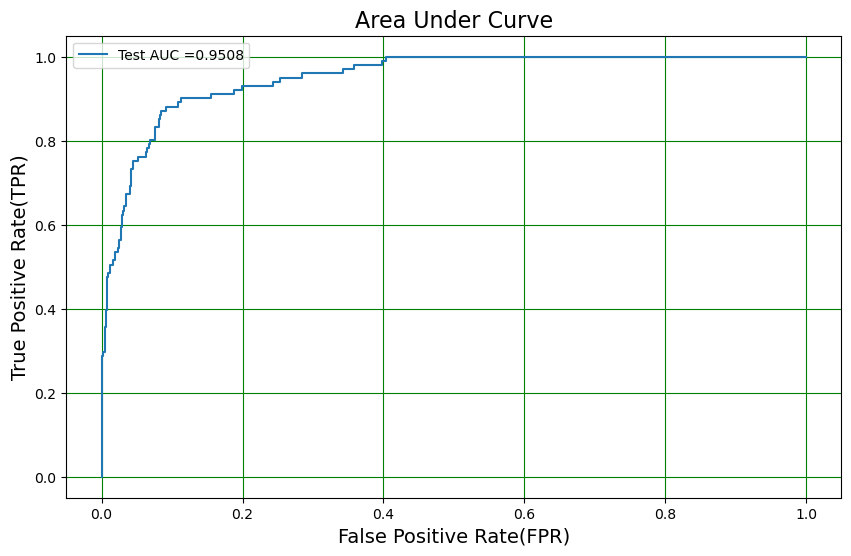

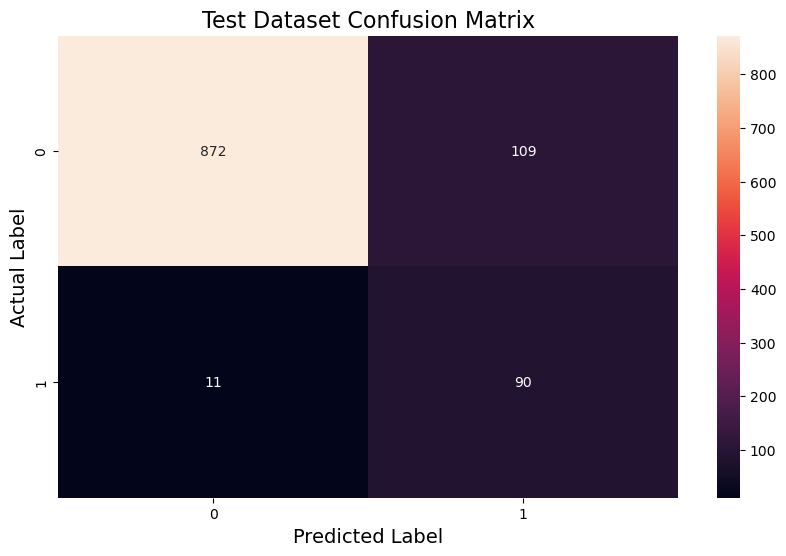

In [43]:
# call final_fun_2 for prediction
x_test_provider, test_auc, test_f1_score = final_fun_2(X)

In [44]:
# print actual label along with predicted label
x_test_provider.head()

,Provider,PotentialFraud,predicted_label
0,PRV51005,1,1
1,PRV51008,0,0
2,PRV51011,0,0
3,PRV51012,0,0
4,PRV51016,0,0


In [45]:
x_test_provider.tail()

,Provider,PotentialFraud,predicted_label
1077,PRV57747,0,0
1078,PRV57748,0,0
1079,PRV57756,0,0
1080,PRV57758,0,0
1081,PRV57759,0,0


In [46]:
executionTime = (time.time() - startTime)
print('Execution time in seconds: ' + str(executionTime))
print('Execution time in minutes: ' + str(executionTime/60))

Execution time in seconds: 86.60156512260437
Execution time in minutes: 1.443359418710073
